In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
%matplotlib inline
from pandas import DataFrame


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
r = requests.get("https://covid-mgzrmsj5kq-uc.a.run.app/API/usa/timeseries/")
response_dict = r.json()
dataset = pd.DataFrame.from_dict(response_dict)
dataset = dataset.rename(columns={'Total Results as of Date': 'Date'})
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset[dataset.Cases >= 20000]

dataset = dataset.set_index("Date")


#### A stationary (time) series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time.

#### We can check stationarity using:
####  * Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. 
#### The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [4]:
### Testing For Stationarity - Dickey-Fuller Test
#Ho: It is non stationary
#H1: It is stationary

from statsmodels.tsa.stattools import adfuller

test_result=adfuller(dataset['Cases'])

def adfuller_test(Cases):
    result=adfuller(Cases)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")



In [5]:
# Test the whole dataset
adfuller_test(dataset['Cases'])

ADF Test Statistic : -3.9110325681909193
p-value : 0.0019551371698513695
#Lags Used : 6
Number of Observations Used : 45
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Make the timeseries stationary with Differencing

In [6]:
dataset['NewCases_7'] = dataset['Cases'] - dataset['Cases'].shift(7)
dataset['NewCases_14'] = dataset['Cases'] - dataset['Cases'].shift(14)



In [7]:
adfuller_test(dataset['NewCases_7'].dropna())

ADF Test Statistic : -3.2378042301679915
p-value : 0.01789808926080621
#Lags Used : 2
Number of Observations Used : 42
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [8]:
adfuller_test(dataset['NewCases_14'].dropna())

ADF Test Statistic : -5.45815558504858
p-value : 2.5539766535812462e-06
#Lags Used : 0
Number of Observations Used : 37
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


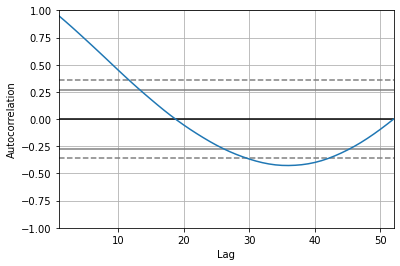

In [9]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dataset['Cases'])
plt.show()

### ARIMA (the time series data must be stationary) 

#### ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:
1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results. An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2.	Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.



/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


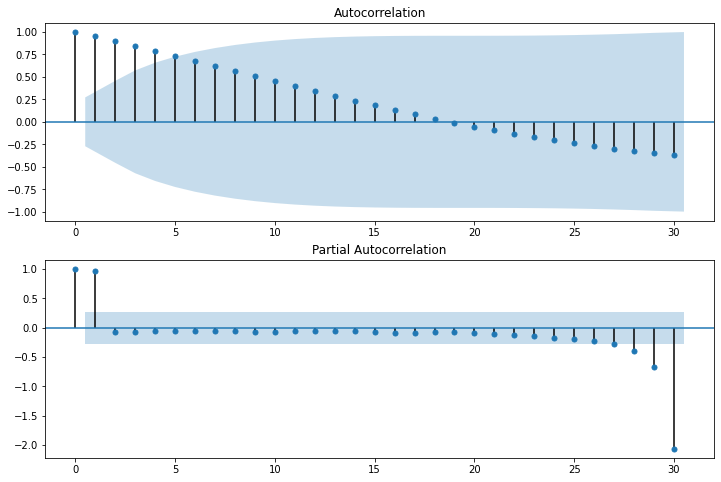

In [10]:
#ACF and PACF plots:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['Cases'],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['Cases'],lags=30,ax=ax2)


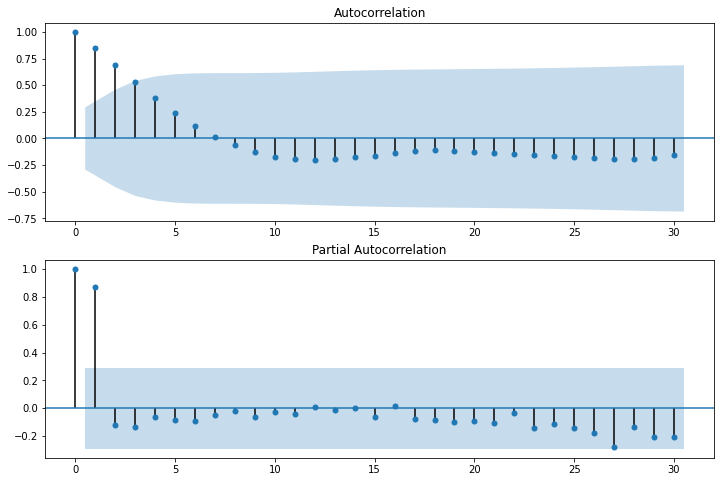

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['NewCases_7'].iloc[7:],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['NewCases_7'].iloc[7:],lags=30,ax=ax2)

#### 

In [12]:
# For non-seasonal data
#p=5, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(dataset['Cases'],order=(5,1,1))
model_fit=model.fit()

/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [13]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Cases   No. Observations:                   51
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -479.477
Method:                       css-mle   S.D. of innovations           2856.293
Date:                Tue, 12 May 2020   AIC                            974.954
Time:                        18:07:17   BIC                            990.409
Sample:                    03-22-2020   HQIC                           980.860
                         - 05-11-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.061e+04   6352.082      3.245      0.001    8165.097    3.31e+04
ar.L1.D.Cases     1.1106      0.330      3.361      0.001       0.463       1.758
ar.L2.D.Cases    -0.1417      0.390     -0.363      0.716      -0.906       0.623
ar.L3.D.Cases    -0.2808      0.216     -1.299      0.194      -0.705       0.143
ar.L4.D.Cases     0.0802      0.239      0.336      0.737      -0.387       0.548
ar.L5.D.Cases     0.1886      0.172      1.094      0.274      -0.149       0.526
ma.L1.D.Cases    -0.0954      0.311     -0.307      0.759      -0.704       0.514
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0333           -0.0000j            1.0333           -0.0000
AR.2            0.7980           -0.9407j            1.2336           -0.1380
AR.3            0.7980           +0.9407j            1.2336            0.1380
AR.4           -1.5272           -1.0193j            1.8361           -0.4063
AR.5           -1.5272           +1.0193j            1.8361            0.4063
MA.1           10.4773           +0.0000j           10.4773            0.0000
-----------------------------------------------------------------------------
"""

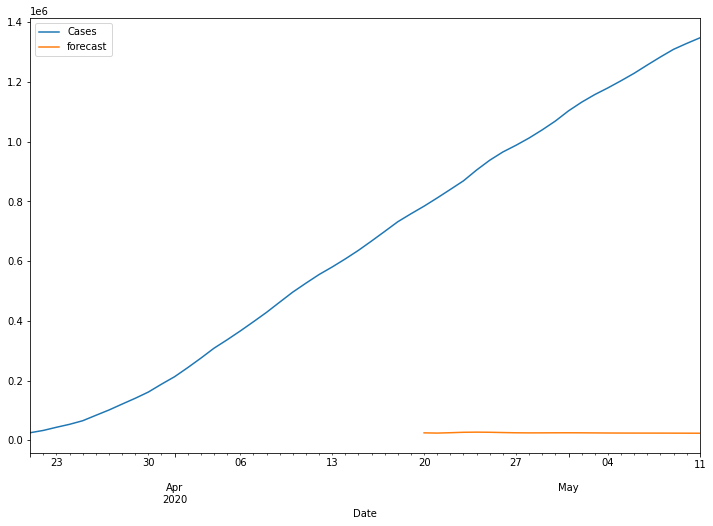

In [14]:
dataset['forecast']=model_fit.predict(start=30,end=115,dynamic=True)
dataset[['Cases','forecast']].plot(figsize=(12,8))

In [15]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(dataset['Cases'],order=(4, 3, 1))
results=model.fit()

/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/daniela/.local/share/virtualenvs/project3-n0KAOclj/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


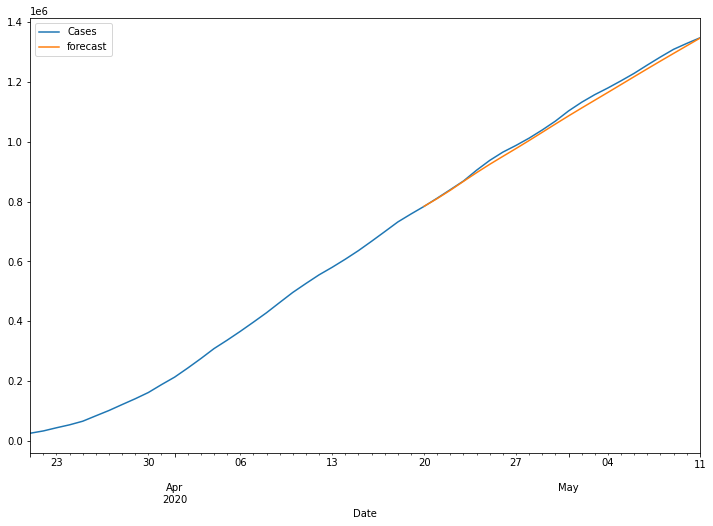

In [16]:
dataset['forecast']=results.predict(start=30,end=115,dynamic=True)
dataset[['Cases','forecast']].plot(figsize=(12,8))

In [26]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=dataset.columns)
future_datest_df.tail()


,ISO3,Country,Cases,Deaths,Recovered,NewCases_7,NewCases_14,forecast
2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
future_df=pd.concat([dataset,future_datest_df])


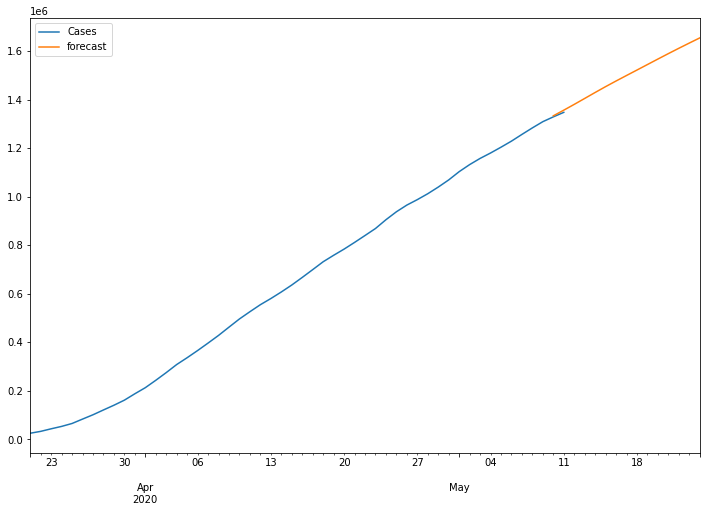

In [28]:
future_df['forecast'] = results.predict(start = 50, end = 114, dynamic= True) 

future_df[['Cases', 'forecast']].plot(figsize=(12, 8))

In [29]:
future_df.tail(20)

,ISO3,Country,Cases,Deaths,Recovered,NewCases_7,NewCases_14,forecast
2020-05-05,USA,US,1204351,71064,189791,191769.000,392486.000,nan
2020-05-06,USA,US,1229331,73455,189910,189422.000,388980.000,nan
2020-05-07,USA,US,1257023,75662,195036,187599.000,387853.000,nan
2020-05-08,USA,US,1283929,77180,198993,180468.000,378571.000,nan
2020-05-09,USA,US,1309550,78795,212534,177011.000,371396.000,nan
2020-05-10,USA,US,1329260,79526,216169,171220.000,363475.000,1333600.841
2020-05-11,USA,US,1347881,80682,232733,167506.000,359684.000,1356915.223
2020-05-12,NaN,NaN,NaN,NaN,NaN,nan,nan,1380782.924
2020-05-13,NaN,NaN,NaN,NaN,NaN,nan,nan,1405229.362
2020-05-14,NaN,NaN,NaN,NaN,NaN,nan,nan,1429852.724


In [30]:
future_df[future_df['forecast'].notnull() & (future_df['Cases'].isnull())]


,ISO3,Country,Cases,Deaths,Recovered,NewCases_7,NewCases_14,forecast
2020-05-12,NaN,NaN,NaN,NaN,NaN,nan,nan,1380782.924
2020-05-13,NaN,NaN,NaN,NaN,NaN,nan,nan,1405229.362
2020-05-14,NaN,NaN,NaN,NaN,NaN,nan,nan,1429852.724
2020-05-15,NaN,NaN,NaN,NaN,NaN,nan,nan,1453938.163
2020-05-16,NaN,NaN,NaN,NaN,NaN,nan,nan,1477180.457
2020-05-17,NaN,NaN,NaN,NaN,NaN,nan,nan,1499851.462
2020-05-18,NaN,NaN,NaN,NaN,NaN,nan,nan,1522364.524
2020-05-19,NaN,NaN,NaN,NaN,NaN,nan,nan,1544987.823
2020-05-20,NaN,NaN,NaN,NaN,NaN,nan,nan,1567635.791
2020-05-21,NaN,NaN,NaN,NaN,NaN,nan,nan,1590036.486


In [31]:
print((future_df['forecast'][40:]))


2020-04-30           nan
2020-05-01           nan
2020-05-02           nan
2020-05-03           nan
2020-05-04           nan
2020-05-05           nan
2020-05-06           nan
2020-05-07           nan
2020-05-08           nan
2020-05-09           nan
2020-05-10   1333600.841
2020-05-11   1356915.223
2020-05-12   1380782.924
2020-05-13   1405229.362
2020-05-14   1429852.724
2020-05-15   1453938.163
2020-05-16   1477180.457
2020-05-17   1499851.462
2020-05-18   1522364.524
2020-05-19   1544987.823
2020-05-20   1567635.791
2020-05-21   1590036.486
2020-05-22   1611993.860
2020-05-23   1633509.541
2020-05-24   1654739.980
Name: forecast, dtype: float64


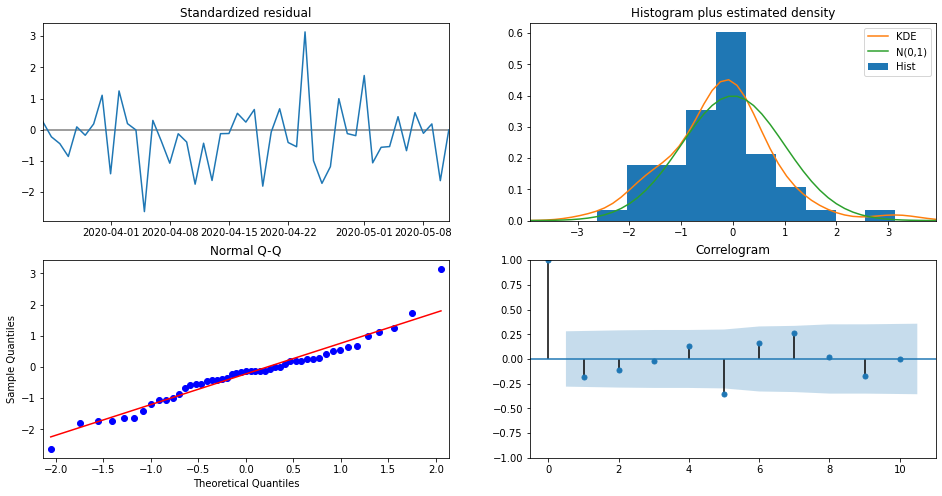

In [32]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()